## Neural networks for approximating functions
This notebook is intended as a practice ground to learn how to use neural networks for approximating functions, are NNs are universal.

In [1]:
# import libraries
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score

In [2]:
# define function
f = lambda x: -5

In [3]:
# define interior points of x
num_interior_points = 1000
#x_interior = torch.rand(num_interior_points, 2, requires_grad=True)
x_grid = torch.linspace(0, 10, steps=num_interior_points, requires_grad=True).view(-1, 1)
y_grid = torch.linspace(0, 10, steps=num_interior_points, requires_grad=True).view(-1, 1)
x_interior = torch.cat((x_grid, y_grid), 1)

#define boundary points
x_bottom = torch.linspace(0, 1, 100).view(-1, 1)
y_bottom = torch.zeros(100, 1)
u_bottom = torch.zeros(100, 1)

x_top = torch.linspace(0, 1, 100).view(-1, 1)
y_top = torch.ones(100, 1)
u_top = torch.ones(100, 1)

x_left = torch.zeros(100, 1)
y_left = torch.linspace(0, 1, 100).view(-1, 1)
u_left = torch.zeros(100, 1)

x_right = torch.ones(100, 1)
y_right = torch.linspace(0, 1, 100).view(-1, 1)
u_right = torch.ones(100, 1)

x_boundary = torch.cat((torch.cat((x_bottom, y_bottom), 1),
                        torch.cat((x_top, y_top), 1),
                        torch.cat((x_left, y_left), 1),
                        torch.cat((x_right, y_right), 1)), 0)
u_boundary = torch.cat((u_bottom, u_top, u_left, u_right), 0)


#optional: standardize data
#mean = x_interior.mean(dim=0, keepdim=True)
#std = x_interior.std(dim=0, keepdim=True)
#x_interior = (x_interior - mean) / std
#x_boundary = (x_boundary - mean) / std

In [4]:
# define functions

def poisson_residual(net, x, f):
    u = net(x)
    
    # Compute first derivatives of u with respect to x and y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    # Compute second derivatives of u with respect to x and y
    u_xx = torch.autograd.grad(u_x[:, 0], x, grad_outputs=torch.ones_like(u_x[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_x[:, 1], x, grad_outputs=torch.ones_like(u_x[:, 1]), create_graph=True)[0][:, 1]
    
    # Calculate Laplacian of u
    laplacian_u = u_xx + u_yy
    
    # Calculate residual
    residual = laplacian_u - f(x)
    
    return residual

def loss_pde(net, x_interior, f):
    # Poisson residual for interior points
    residual = poisson_residual(net, x_interior, f)
    loss_pde = torch.mean(residual**2)
    return loss_pde

def loss_bc(net, x_boundary, u_boundary, f):
    # Boundary condition for boundary points
    u_pred = net(x_boundary)
    loss_bc = torch.mean((u_pred - u_boundary)**2)
    return loss_bc

Text(0, 0.5, 'y')

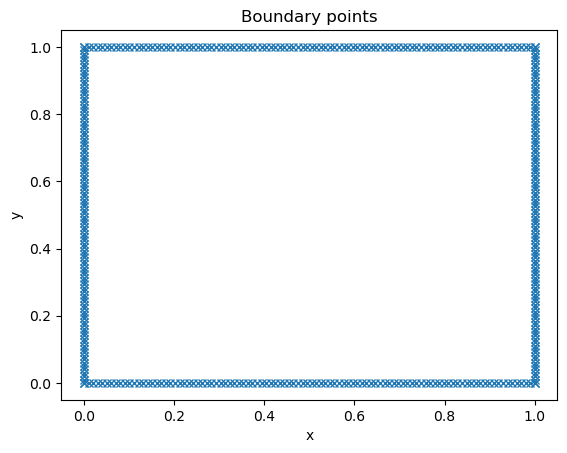

In [5]:
# plot boundary points
plt.plot(x_boundary[:,0].detach().numpy(), x_boundary[:,1].detach().numpy(), marker="x", linestyle="")
plt.title("Boundary points")
plt.xlabel("x")
plt.ylabel("y")

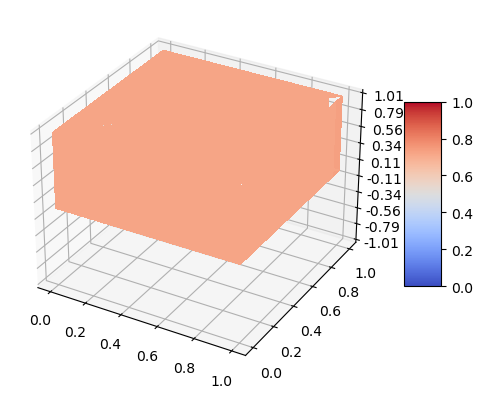

In [6]:
# still work in progess
# plot boundary conditions
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(x_boundary[:,0].detach().numpy(), x_boundary[:,1].detach().numpy(), u_boundary[:].detach().numpy(), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [7]:
# define network architecture
input_dim = 2
output_dim = 1
num_hidden = 200

class Net(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, output_dim),
        )

    def forward(self, x):
        y_out = self.linear_relu_stack(x)
        return y_out
    
net = Net(num_hidden)
    
# hyperparameters
learning_rate = 1e-3
batch_size = 50
num_epochs = 10000

#optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [8]:
# train network

#getting epoch sizes
num_samples_train = x_interior.shape[0]
num_batches_train = num_samples_train // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
#test_acc, test_loss = [], []
cur_loss = 0
losses, pde_losses, bc_losses = [], [], []

get_slice = lambda i, size: range(i * size, (i + 1) * size) #get slices for each batch

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    pde_loss = 0
    bc_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_interior[slce, :])

        # compute gradients given loss
#        y_batch = train_y[slce]
        batch_loss_pde = loss_pde(net, x_interior, f)
        batch_loss_bc = loss_bc(net, x_boundary, u_boundary, f)
        batch_loss = batch_loss_pde + batch_loss_bc
        batch_loss.backward()
        #check if pde_loss has gradient
        assert any(param.grad is not None for param in net.parameters()) == True
        optimizer.step()

        cur_loss += batch_loss
        pde_loss += batch_loss_pde
        
        bc_loss += batch_loss_bc
    losses.append(cur_loss / batch_size)
    pde_losses.append(pde_loss / batch_size)
    bc_losses.append(bc_loss / batch_size)

    net.eval()

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1} : Total loss {losses[-1]}, Pde loss: {pde_losses[-1]}, Bc loss: {bc_losses[-1]}")

epoch = np.arange(len(losses))
plt.figure()
plt.plot(epoch, losses, 'r')
plt.legend(['Losses'])
plt.xlabel('Updates'), plt.ylabel('Loss')

Epoch 1 : Total loss 10.0, Pde loss: 10.0, Bc loss: 0.18588024377822876
Epoch 6 : Total loss 10.0, Pde loss: 10.0, Bc loss: 0.18588024377822876
Epoch 11 : Total loss 10.0, Pde loss: 10.0, Bc loss: 0.18588024377822876
Epoch 16 : Total loss 10.0, Pde loss: 10.0, Bc loss: 0.18588024377822876
Epoch 21 : Total loss 10.0, Pde loss: 10.0, Bc loss: 0.18588024377822876


KeyboardInterrupt: 

## Work in progress visualization

In [ ]:
#predicted values for u by the trained net for the interior point    
u = net(x_interior).detach().numpy()

#interpolate data for visualization
x = x_interior[:,0].detach().numpy()
y = x_interior[:,1].detach().numpy()
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
ui = griddata((x, y), u, (xi, yi), method='cubic')

In [ ]:
plt.figure(figsize=(10, 8))
plt.contourf(xi, yi, ui, 100, cmap='viridis')
plt.colorbar(label='u value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heat Map of u(x, y)')
plt.show()